<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/WGAN-GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install librosa

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import Audio

In [4]:
import librosa
import numpy as np

def create_mel_spectrogram(audio_array, sample_rate):
    # Compute the Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=np.squeeze(audio_array), sr=sample_rate)

    # Convert to decibels
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db


def create_mel_spectrograms(audio_array, sample_rate):
    num_samples, _, _ = audio_array.shape
    num_mels = 128  # Number of Mel bins
    hop_length = 512  # Hop length for the spectrogram

    mel_spectrograms = []

    for i in range(num_samples):
        # Compute the Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=np.squeeze(audio_array[i]), sr=sample_rate, hop_length=hop_length, n_mels=num_mels)

        # Convert to decibels
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Append the Mel spectrogram to the list
        mel_spectrograms.append(mel_spectrogram_db)

    # Convert the list of Mel spectrograms to a numpy array
    mel_spectrograms = np.array(mel_spectrograms)

    # Reshape the array to match the desired dimensions
    mel_spectrograms = mel_spectrograms.reshape(num_samples, num_mels, -1, 1)

    return mel_spectrograms

def plot_spec(array,sample_rate):
    # Plot the Mel spectrogram
    reshaped_array = np.squeeze(array)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(reshaped_array, x_axis='time', y_axis='mel', sr=sample_rate, fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.show()
def downsample_array(arr, factor, axis):
    return arr.take(np.arange(0, arr.shape[axis], factor), axis)

def create_sliding_window(array, window_size, stride):
    num_windows = (len(array) - window_size) // stride + 1
    sliding_windows = np.lib.stride_tricks.sliding_window_view(array, (window_size,))

    return sliding_windows[::stride]

In [5]:
reduction = 12
wav_file = '/content/drive/MyDrive/bass samples/NBKoanbandstuff.wav'
audio, sr = librosa.load(wav_file, sr=None)
audio_dev = np.std(audio)
audio = audio/audio_dev
result_array = create_sliding_window(audio,44100,100)
result_array = np.expand_dims(result_array, axis=2)
result_array = downsample_array(result_array,reduction,1)

(100, 128, 8, 1)


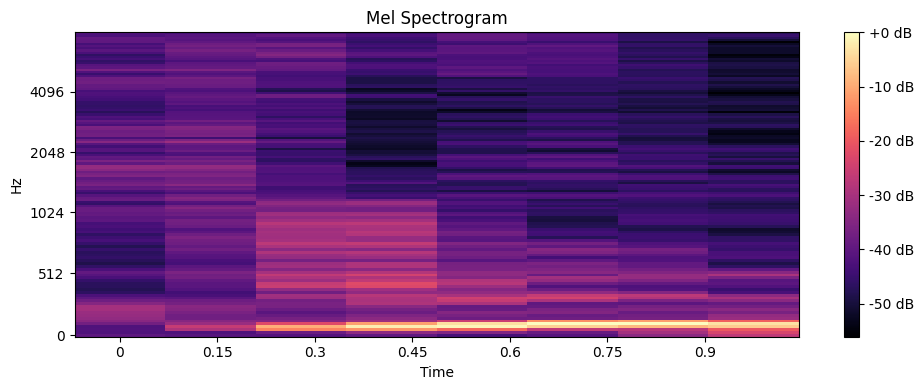

In [6]:


spec = create_mel_spectrograms(result_array[100:200],sr/reduction)
print(spec.shape)
plot_spec(spec[0],sr/reduction)
audio_data = result_array[100].ravel()
# Play the audio within the Jupyter Notebook
Audio(data=audio_data, rate=sr/reduction)

In [7]:
#x_train = noise
y_train = result_array
print(y_train[0].shape)

(3675, 1)


In [8]:
class ResNetBlock(layers.Layer):
    def __init__(self, filters,kernel_size=3, strides=1,dilation_rate=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = layers.Conv1D(filters, kernel_size, strides=strides,dilation_rate=dilation_rate, padding='same')
        self.conv2 = layers.Conv1D(filters, kernel_size, padding='same')

        if strides != 1:
            self.residual = layers.Conv1D(filters, 1, strides=strides)
        else:
            self.residual = lambda x: x

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = tf.nn.relu(x)
        x = self.conv2(x)

        r = self.residual(inputs)

        x += r
        return tf.nn.relu(x)

In [9]:
class ResNetBlockup(layers.Layer):
    def __init__(self, filters, kernel_size=3, strides=1, dilation_rate=1):
        super(ResNetBlockup, self).__init__()
        self.conv1 = layers.Conv1DTranspose(filters, kernel_size, strides=strides, dilation_rate=dilation_rate, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv1DTranspose(filters, kernel_size, padding='same')
        self.bn2 = layers.BatchNormalization()

        if strides != 1:
            self.residual = layers.Conv1DTranspose(filters, 1, strides=strides)
        else:
            self.residual = lambda x: x

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        r = self.residual(inputs)

        x += r
        return tf.nn.relu(x)

In [10]:
def build_discriminator():
    input_series = layers.Input(shape=(None, 1))
    input_img = layers.Input(shape=(None, None, 1))

    # Convolutional layers for series
    x_series = ResNetBlock(64, 3, 2, 1)(input_series)
    x_series = layers.LayerNormalization()(x_series)

    x_series = ResNetBlock(64, 3, 2, 1)(x_series)
    x_series = layers.LayerNormalization()(x_series)

    x_series = ResNetBlock(64, 3, 2, 1)(x_series)
    x_series = layers.LayerNormalization()(x_series)

    x_series = ResNetBlock(512, 3, 2, 1)(x_series)
    x_series = layers.LayerNormalization()(x_series)

    # Convolutional layers for image
    x_img = layers.Conv2D(64,5,2,padding='same')(input_img)
    x_img = layers.LayerNormalization()(x_img)

    x_img = layers.Conv2D(64,3,2,padding='same')(x_img)
    x_img = layers.LayerNormalization()(x_img)

    x_img = layers.Conv2D(64,3,2,padding='same')(x_img)
    x_img = layers.LayerNormalization()(x_img)

    x_img = ResNetBlock(512, 3, 2, 1)(x_img)
    x_img = layers.LayerNormalization()(x_img)

    # Concatenate series and image features


    # Global pooling
    pooled_series = layers.GlobalAveragePooling1D()(x_series)
    pooled_img = layers.GlobalAveragePooling2D()(x_img)
    pooled_output = layers.Concatenate()([pooled_series, pooled_img])


    # Dense layers
    dense_output = layers.Dense(200, activation='relu')(pooled_output)
    dense_output = layers.LayerNormalization()(dense_output)

    dense_output = layers.Dense(64, activation='relu')(dense_output)

    dense_output = layers.Dense(1, activation='linear')(dense_output)

    model = tf.keras.models.Model(inputs=[input_series, input_img], outputs=dense_output)
    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 res_net_block (ResNetBlock)    (None, None, 64)     12736       ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   1664        ['input_2[0][0]']            

In [11]:
def build_generator():
    input_series = layers.Input(shape=(None,1))

    x = layers.BatchNormalization()(input_series)

    x = ResNetBlock(64,4,strides=1,dilation_rate=24)(x)

    x = ResNetBlock(64,4,strides=1,dilation_rate=12)(x)

    x = ResNetBlock(64,4,strides=1,dilation_rate=6)(x)

    x = ResNetBlock(64,4,strides=1,dilation_rate=4)(x)

    x = ResNetBlock(64,4,strides=1,dilation_rate=2)(x)

    x = ResNetBlock(64,4,strides=1,dilation_rate=1)(x)

    x = layers.Conv1D(1,1)(x)



    model = tf.keras.models.Model(inputs=input_series, outputs=x)
    return model

generator = build_generator()
generator.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 batch_normalization (BatchN  (None, None, 1)          4         
 ormalization)                                                   
                                                                 
 res_net_block_5 (ResNetBloc  (None, None, 64)         16768     
 k)                                                              
                                                                 
 res_net_block_6 (ResNetBloc  (None, None, 64)         32896     
 k)                                                              
                                                                 
 res_net_block_7 (ResNetBloc  (None, None, 64)         32896     
 k)                                                        

In [19]:
# Compile models
#generator_optimizer = tf.keras.optimizers.Adam(0.0004)
#discriminator_optimizer = tf.keras.optimizers.Adam(0.0004)

generator_optimizer = tf.keras.optimizers.experimental.SGD(1e-4)
discriminator_optimizer = tf.keras.optimizers.experimental.SGD(1e-4)

In [13]:
def gradient_penalty(real, fake, discriminator):
    batch_size = real.shape[0]
    epsilon = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
    interpolated = epsilon * real + (1 - epsilon) * fake

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = discriminator(interpolated, training=True)

    gradients = tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)

    return gp

def gradient_penalty(real, fake, discriminator):
    batch_size = real.shape[0]
    epsilon = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
    interpolated = epsilon * real + (1 - epsilon) * fake

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = discriminator([interpolated, interpolated], training=True)

    gradients = tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)

    return gp

In [14]:
def discriminator_loss(real_output, fake_output, gradient_penalty):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) + gradient_penalty

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)



In [15]:
def clip_discriminator_weights(discriminator):
    for l in discriminator.layers:
        weights = l.get_weights()
        weights = [tf.clip_by_value(w, -0.01, 0.01) for w in weights]
        l.set_weights(weights)

In [16]:
def print_img(generator_model):
    # Generate and save sample images
    noise = tf.random.normal([10, 100])
    sampled_labels = tf.constant([[i % 10] for i in range(10)], dtype=tf.int32)
    generated_images = generator_model.predict([noise, sampled_labels])
    fig, axs = plt.subplots(1, 10, figsize=(10, 10))
    for i in range(10):
        axs[i].imshow(generated_images[i], cmap="gray")
        axs[i].axis("off")
    plt.show()

In [17]:
noise = tf.random.normal(shape=(1,10000,1))

test = generator.predict(noise)
print(test.shape)

1/1 [==============================] - 1s 745ms/step
(1, 10000, 1)


In [20]:

#@tf.function
def train_step(target_audios):
  real_spec = create_mel_spectrograms(target_audios,sr/reduction)

  for i in range(2):

      # Get the shape of the target_audios tensor
      shape = tf.shape(target_audios)


      # Generate noise using tf.random.normal()
      noise = tf.random.normal((shape))
      generated_audio = generator(noise, training=True)
      fake_spec = create_mel_spectrograms(generated_audio,sr/reduction)
      with tf.GradientTape() as disc_tape:

          real_output = discriminator((target_audios,real_spec), training=True)
          fake_output = discriminator((generated_audio,fake_spec), training=True)


          gp = gradient_penalty(target_audios, generated_audio, discriminator)
          disc_loss = discriminator_loss(real_output, fake_output, gp)

      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
      #clip_discriminator_weights(discriminator)

      if i ==0:
          weights = discriminator.get_weights()


  with tf.GradientTape() as gen_tape:
    noise = tf.random.normal(shape=(target_audios.shape))
    generated_audio = generator(noise, training=True)
    fake_spec = create_mel_spectrograms(generated_audio,sr/reduction)
    fake_output = discriminator((generated_audio,fake_spec), training=True)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

  discriminator.set_weights(weights)


  tf.print("disc_loss",disc_loss,'gen_loss',gen_loss)


def train(generator, discriminator
          , epochs, batch_size):
    for epoch in range(epochs):
        for batch in range(len(y_train) // batch_size):
            #images = x_train[batch * batch_size: (batch+1) * batch_size]
            target_audios = y_train[batch * batch_size: (batch+1) * batch_size]

            train_step(target_audios)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            test = generator.predict(noise)
            audio_data = test.ravel()
            # Play the audio within the Jupyter Notebook
            Audio(data=audio_data, rate=sr/reduction)


# Train the GAN
EPOCHS = 2000000
BATCH_SIZE = 10
num_unrolling_steps = 20  # Set the desired number of unrolling steps
train(generator, discriminator, EPOCHS, BATCH_SIZE)

disc_loss 0.65817064 gen_loss -0.404653221
disc_loss -0.011720717 gen_loss -0.0804180726
disc_loss -0.489937 gen_loss 0.192444578
disc_loss -0.83331722 gen_loss 0.441377163
disc_loss -1.0209496 gen_loss 0.574063838
disc_loss -1.19532752 gen_loss 0.721312702
disc_loss -1.38462758 gen_loss 0.782324
disc_loss -1.45775485 gen_loss 0.869973
disc_loss -1.49036777 gen_loss 0.815374672
disc_loss -1.12096334 gen_loss 0.510226786
disc_loss -0.70355 gen_loss -0.0441826731
disc_loss -0.239875019 gen_loss -0.652964592
disc_loss -0.00504666567 gen_loss -0.951007962
disc_loss 0.0268354416 gen_loss -1.09699368
disc_loss -0.0113361478 gen_loss -1.10951197
disc_loss -0.112922251 gen_loss -1.12412441
disc_loss -0.263746023 gen_loss -1.10803366
disc_loss -0.27853626 gen_loss -1.02459264
disc_loss -0.403536439 gen_loss -0.95506084
disc_loss -0.467119753 gen_loss -0.900709808
disc_loss -0.603352606 gen_loss -0.837749839
disc_loss -0.688275158 gen_loss -0.752061
disc_loss -0.84348309 gen_loss -0.666221261
di

KeyboardInterrupt: ignored

In [21]:
test = generator.predict(noise)
audio_data = test.ravel()
# Play the audio within the Jupyter Notebook
Audio(data=audio_data, rate=sr/reduction)

1/1 [==============================] - 0s 320ms/step
